# Elasticity equation in mixed form

In this tutorial we present how to solve the elasticity equation with [PyGeoN](https://github.com/compgeo-mox/pygeon) in mixed form.  The unknowns are the stress $\sigma$, the displacement $u$, and the rotation $r$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$\lambda$ Lamé constant and $\mu$ the Kirchhoff modulus, we want to solve the following problem: find $(\sigma, u, r)$ such that
\begin{align*}
&A \sigma - \nabla u - {\rm asym}^* r = 0\\
&\nabla \cdot \sigma = - b\\
&{\rm asym}\, \sigma = 0
\end{align*}
with $b$ a body force, which is set to $0$ in this example.
The operator $A$ is defined as
$$
A \sigma = \frac{1}{2\mu}\left( \sigma -\frac{\lambda}{2\mu + d \lambda} {\rm Tr}(\sigma) I\right)
$$
with $d$ the dimension of the domain, here $d=2$.
Finally, ${\rm asym}$ is the asymmetric operator, which is defined as followed
$$
    {\rm asym }\, \sigma = \begin{bmatrix}
        \sigma_{32} - \sigma_{23} \\
        \sigma_{13} - \sigma_{31} \\
        \sigma_{21} - \sigma_{12}
    \end{bmatrix} 
    \qquad
    {\rm asym}^* r =
    \begin{bmatrix}
        0    & -r_3 & r_2  \\
        r_3  & 0    & -r_1 \\
        -r_2 & r_1  & 0
    \end{bmatrix}
    \qquad
    d = 3
$$
$$
    {\rm asym} \, \sigma  = \sigma_{21} - \sigma_{12} \qquad
    {\rm asym}^* r =
    \begin{bmatrix}
        0 & -r \\
        r & 0
    \end{bmatrix} \qquad
    d = 2.
$$
For this test case we set the following boundary conditions related to the so-called footstep problem:
$$ u = 0 \text{ on } \partial_{bottom} \Omega \qquad \nu \cdot \sigma = [0, 0]^\top \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \qquad \nu \cdot \sigma = [0, -1e-3]^\top \text{ on } \partial_{top} \Omega$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
import os
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

We create now the grid, since we use vector BDM1 for ${\sigma}$, vector piece-wise constant for $u$ and piece-wise constant for $r$, we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 3d with the only attention that in 3d the rotations should be discretized with vector piece-wise constant finite elements.

In [2]:
mesh_size = 0.1
dim = 2

sd = pg.unit_grid(dim, mesh_size, as_mdg=False)
sd.compute_geometry()

We define now the finite element spaces for all the variables.

In [3]:
key = "elasticity_mixed"

# finite element spaces
vec_bdm1 = pg.VecBDM1(key)
vec_p0 = pg.VecPwConstants(key)
p0 = pg.PwConstants(key)

# build the degrees of freedom
dofs = np.array([vec_bdm1.ndof(sd), vec_p0.ndof(sd), p0.ndof(sd)])

With the following code we set the data, in particular the Lamé and the Kirchhoff modulus, and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [4]:
param = {pg.LAME_LAMBDA: 1, pg.LAME_MU: 0.5}
data = pp.initialize_data({}, key, param)

# select the portions of the boundary where we want to apply the boundary conditions
bottom = np.isclose(sd.face_centers[1, :], 0)
top = np.isclose(sd.face_centers[1, :], 1)
left = np.isclose(sd.face_centers[0, :], 0)
right = np.isclose(sd.face_centers[0, :], 1)

# select the part of the boundary where we apply the essential boundary conditions
b_faces = np.logical_or.reduce((top, left, right))
ess_dof = np.tile(b_faces, sd.dim**2)

# function for the essential boundary conditions
val = np.array([[0, 0, 0], [0, -1e-3, 0]])
fct = lambda pt: val if np.isclose(pt[1], 1) else 0 * val

# interpolate the essential boundary conditions
ess_val = vec_bdm1.interpolate(sd, fct)

Once the data are assigned to the grid, we construct the matrices. Once the latter is created, we also construct the right-hand side containing the boundary conditions.

In [5]:
# assemble mass matrices
Ms = vec_bdm1.assemble_mass_matrix_elasticity(sd, data)
Mu = vec_p0.assemble_mass_matrix(sd)
Mr = p0.assemble_mass_matrix(sd)

# assemble matrices associated with the divergence and asymmetry operators
div = Mu @ vec_bdm1.assemble_diff_matrix(sd)
asym = Mr @ vec_bdm1.assemble_asym_matrix(sd, as_pwconstant=True)

# assemble the saddle point problem matrix
spp = sps.block_array(
    [
        [Ms, div.T, -asym.T],
        [-div, None, None],
        [asym, None, None],
    ],
    format="csc",
)

We need to solve the linear system, PyGeoN provides a framework for that. The actual imposition of essential boundary conditions (stress boundary conditions) might change the symmetry of the global system, the class `pg.LinearSystem` preserves this structure by internally eliminating these degrees of freedom.

In [6]:
# solve the linear system
ls = pg.LinearSystem(spp, np.zeros(spp.shape[0]))
ls.flag_ess_bc(np.where(ess_dof)[0], ess_val)
x = ls.solve()

# split the solution into the components
idx = np.cumsum(dofs[:-1])
sigma, u, r = np.split(x, idx)

We finally export the solution to be visualized by [ParaView](https://www.paraview.org/).

In [7]:
# post process of the displacement
proj_u = vec_p0.eval_at_cell_centers(sd)
cell_u = (proj_u @ u).reshape((sd.dim, -1))
# since we are in 2d we need to add the z component for the exporting
cell_u = np.vstack((cell_u, np.zeros(cell_u.shape[1])))

# post process of the rotation
proj_r = p0.eval_at_cell_centers(sd)
cell_r = proj_r @ r

# export the solution
folder_name = os.path.join(os.getcwd(), key)
file_name = "sol"

save = pp.Exporter(sd, file_name, folder_name=folder_name)
save.write_vtu([("cell_u", cell_u), ("cell_r", cell_r)])

A representation of the computed solution is given below.

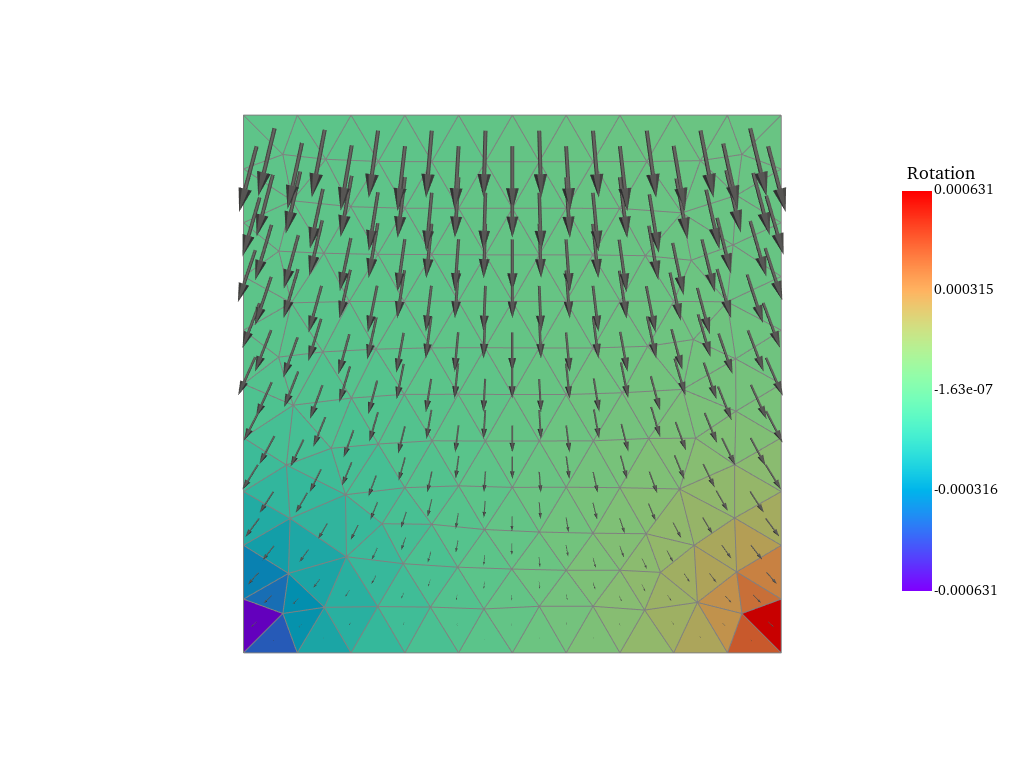

In [8]:
# NBIGNORE
file_name_vtu = file_name + "_2.vtu"
vis = pg.Visualizer(sd.dim, file_name_vtu, folder_name)

vis.vector_field("cell_u", scaling_factor=200)
vis.scalar_field("cell_r", "Rotation")

vis.show()

In [9]:
# Consistency check
assert np.isclose(np.linalg.norm(sigma), 0.0019707271661893073)
assert np.isclose(np.linalg.norm(u), 2.445246631942562e-05)
assert np.isclose(np.linalg.norm(r), 7.1963907702961e-06)
